# Project: Global Patterns in Mental Health

Mental health is a critical component of global well-being, yet the prevalence of mental health disorders varies widely across countries and over time. In this notebook, we explore global trends in mental health disorders and investigate how socioeconomic indicators—such as GDP, population, and life expectancy—relate to these patterns.

For this project, we use the Mental Illnesses Prevalence dataset from [Kaggle: Mental Health Dataset](https://www.kaggle.com/datasets/imtkaggleteam/mental-health/data?select=1-+mental-illnesses-prevalence.csv
) along with World Bank socioeconomic indicators. 

### Understanding the Data
The Kaggle Mental Health Dataset provides country-level, age-standardized prevalence rates for major mental health disorders—including depression, anxiety, bipolar disorder, schizophrenia, and eating disorders—from 1990 to 2019 for over 200 countries. Socioeconomic features such as population (SP.POP.TOTL), life expectancy (SP.DYN.LE00.IN), and GDP (constant 2015 USD, NY.GDP.MKTP.KD) are collected from the World Bank to analyze how economic and demographic factors relate to global mental health trends.

### Read in the Data

In [1]:
!pip install -q pandas-datareader

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import wbdata
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load the mental illness prevalence dataset from the 'data' folder into a DataFrame
mh_df = pd.read_csv("data/mental-illnesses-prevalence.csv")

In [4]:
mh_df.head()

Entity Code  Year  \
0  Afghanistan  AFG  1990   
1  Afghanistan  AFG  1991   
2  Afghanistan  AFG  1992   
3  Afghanistan  AFG  1993   
4  Afghanistan  AFG  1994   

   Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           0.223206                                   
1                                           0.222454                                   
2                                           0.221751                                   
3                                           0.220987                                   
4                                           0.220183                                   

   Depressive disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           4.996118                                
1                                           4.989290                                
2                                           4.981346                                
3                                           4.976958                                
4                                           4.977782                                

   Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           4.713314                             
1                                           4.702100                             
2                                           4.683743                             
3                                           4.673549                             
4                                           4.670810                             

   Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           0.703023                             
1                                           0.702069                             
2                                           0.700792                             
3                                           0.700087                             
4                                           0.699898                             

   Eating disorders (share of population) - Sex: Both - Age: Age-standardized  
0                                           0.127700                           
1                                           0.123256                           
2                                           0.118844                           
3                                           0.115089                           
4                                           0.111815

In [5]:
# Fetching Population and Life Expectancy using wbdata.
# GDP is excluded because wbdata throws a JSON parsing error when requesting NY.GDP.MKTP.KD.

# Indicators: population, life expectancy
indicators = {
    'SP.POP.TOTL': 'Population',
    'SP.DYN.LE00.IN': 'Life_Expectancy'
}

# Fetch all data
pop_lifeexp_df = wbdata.get_dataframe(indicators).reset_index()

In [6]:
pop_lifeexp_df.head()

country  date  Population  Life_Expectancy
0  Afghanistan  1960   9035043.0           32.799
1  Afghanistan  1961   9214083.0           33.291
2  Afghanistan  1962   9404406.0           33.757
3  Afghanistan  1963   9604487.0           34.201
4  Afghanistan  1964   9814318.0           34.673

In [7]:
# GDP (constant 2015 US$) was downloaded manually from the World Bank website,
# and the CSV was reformatted by converting year columns into a long Year–Value format.

gdp_df = pd.read_csv("data/gdp.csv")

In [8]:
gdp_df.head()

Entity Code  Year  GDP (constant 2015 US$)
0                        Aruba  ABW  1960                      NaN
1  Africa Eastern and Southern  AFE  1960             1.524804e+11
2                  Afghanistan  AFG  1960                      NaN
3   Africa Western and Central  AFW  1960             1.095681e+11
4                       Angola  AGO  1960                      NaN

### Data Preperation and Feature Engineering

In [9]:
mh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 8 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Entity                                                                             6420 non-null   object 
 1   Code                                                                               6150 non-null   object 
 2   Year                                                                               6420 non-null   int64  
 3   Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  6420 non-null   float64
 4   Depressive disorders (share of population) - Sex: Both - Age: Age-standardized     6420 non-null   float64
 5   Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized        6420 non-null   float6

In [10]:
# Dropping the 'Code' column because it contains many nulls and the Entity name already uniquely identifies each country.
mh_df = mh_df.drop(columns=["Code"])

In [11]:
# Renaming long disorder column names to shorter, readable labels
mh_df = mh_df.rename(columns={
    "Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized": "Schizophrenia",
    "Depressive disorders (share of population) - Sex: Both - Age: Age-standardized": "Depressive",
    "Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized": "Anxiety",
    "Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized": "Bipolar",
    "Eating disorders (share of population) - Sex: Both - Age: Age-standardized": "Eating_Disorders"
})

In [12]:
mh_df.head()

Entity  Year  Schizophrenia  Depressive   Anxiety   Bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   
3  Afghanistan  1993       0.220987    4.976958  4.673549  0.700087   
4  Afghanistan  1994       0.220183    4.977782  4.670810  0.699898   

   Eating_Disorders  
0          0.127700  
1          0.123256  
2          0.118844  
3          0.115089  
4          0.111815

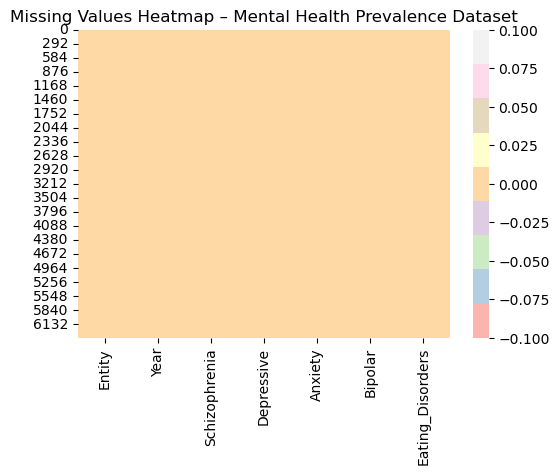

In [13]:
# Heatmap to check missing values
plt.figure(figsize=(6,4)) 
sns.heatmap(mh_df.isna(), cmap="Pastel1")
plt.title("Missing Values Heatmap – Mental Health Prevalence Dataset")
plt.show()

In [14]:
# Check if the dataset contains any duplicate rows
mh_df.duplicated().sum()

0

In [15]:
# Remove the aggregated 'World' entry since it is not a country
mh_df = mh_df[mh_df["Entity"] != "World"]

In [16]:
# Checking the year range in the mental illness prevalence dataset
mh_df["Year"].min(), mh_df["Year"].max()

(1990, 2019)

In [17]:
# Count unique countries in the dataset
mh_df["Entity"].nunique()

213

In [18]:
# Check if any country has missing years (should have exactly 30 rows for 1990–2019)
mh_df["Entity"].value_counts()[mh_df["Entity"].value_counts() != 30]

Series([], Name: count, dtype: int64)

In [19]:
# Rename columns in population and life expectancy data frame to match column names of mh_df
pop_lifeexp_df.rename(columns={'country':'Entity','date':'Year'}, inplace=True)

# Convert Year to int (handle datetime or string)
try:
    pop_lifeexp_df['Year'] = pop_lifeexp_df['Year'].dt.year
except AttributeError:
    pop_lifeexp_df['Year'] = pop_lifeexp_df['Year'].astype(int)

# Filter for 1990–2019 as mh_df year range is only (1990, 2019)
pop_lifeexp_df = pop_lifeexp_df[(pop_lifeexp_df['Year'] >= 1990) & (pop_lifeexp_df['Year'] <= 2019)]

# Sort alphabetically by Entity, then numerically by Year
pop_lifeexp_df = pop_lifeexp_df.sort_values(by=["Entity", "Year"], ascending=[True, True]).reset_index(drop=True)

In [20]:
pop_lifeexp_df.head()

Entity  Year  Population  Life_Expectancy
0  Afghanistan  1990  12045660.0           45.118
1  Afghanistan  1991  12238879.0           45.521
2  Afghanistan  1992  13278974.0           46.569
3  Afghanistan  1993  14943172.0           51.021
4  Afghanistan  1994  16250794.0           50.969

In [21]:
pop_lifeexp_df.info()

<class 'wbdata.api.WBDataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Entity           7980 non-null   object 
 1   Year             7980 non-null   int64  
 2   Population       7950 non-null   float64
 3   Life_Expectancy  7950 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 249.5+ KB


In [22]:
# Identify all rows where either Population or Life Expectancy is missing
pop_lifeexp_df[pop_lifeexp_df[['Population', 'Life_Expectancy']].isnull().any(axis=1)]

Entity  Year  Population  Life_Expectancy
5490  Not classified  1990         NaN              NaN
5491  Not classified  1991         NaN              NaN
5492  Not classified  1992         NaN              NaN
5493  Not classified  1993         NaN              NaN
5494  Not classified  1994         NaN              NaN
5495  Not classified  1995         NaN              NaN
5496  Not classified  1996         NaN              NaN
5497  Not classified  1997         NaN              NaN
5498  Not classified  1998         NaN              NaN
5499  Not classified  1999         NaN              NaN
5500  Not classified  2000         NaN              NaN
5501  Not classified  2001         NaN              NaN
5502  Not classified  2002         NaN              NaN
5503  Not classified  2003         NaN              NaN
5504  Not classified  2004         NaN              NaN
5505  Not classified  2005         NaN              NaN
5506  Not classified  2006         NaN              NaN
5507  Not classified  2007         NaN              NaN
5508  Not classified  2008         NaN              NaN
5509  Not classified  2009         NaN              NaN
5510  Not classified  2010         NaN              NaN
5511  Not classified  2011         NaN              NaN
5512  Not classified  2012         NaN              NaN
5513  Not classified  2013         NaN              NaN
5514  Not classified  2014         NaN              NaN
5515  Not classified  2015         NaN              NaN
5516  Not classified  2016         NaN              NaN
5517  Not classified  2017         NaN              NaN
5518  Not classified  2018         NaN              NaN
5519  Not classified  2019         NaN              NaN

In [23]:
# Remove "Not classified" because it is not an actual country and only contains null values
pop_lifeexp_df = pop_lifeexp_df[pop_lifeexp_df['Entity'] != "Not classified"].copy()

In [24]:
# Dropping the 'Code' column because the Entity name already uniquely identifies each country.
gdp_df = gdp_df.drop(columns=["Code"])

# Rename columns in GDP data frame
gdp_df.rename(columns={'GDP (constant 2015 US$)':'GDP'}, inplace=True)


# Convert Year to int (handle datetime or string)
try:
    gdp_df['Year'] = gdp_df['Year'].dt.year
except AttributeError:
    gdp_df['Year'] = gdp_df['Year'].astype(int)

# Filter for 1990–2019 as mh_df year range is only (1990, 2019)
gdp_df = gdp_df[(gdp_df["Year"] >= 1990) & (gdp_df["Year"] <= 2019)]

# Sort alphabetically by Entity, then numerically by Year
gdp_df = gdp_df.sort_values(by=["Entity", "Year"], ascending=[True, True]).reset_index(drop=True)

In [25]:
gdp_df.head()

Entity  Year  GDP
0  Afghanistan  1990  NaN
1  Afghanistan  1991  NaN
2  Afghanistan  1992  NaN
3  Afghanistan  1993  NaN
4  Afghanistan  1994  NaN

In [26]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Entity  7980 non-null   object 
 1   Year    7980 non-null   int64  
 2   GDP     7488 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 187.2+ KB


In [27]:
# Merge pop_lifeexp_df with gdp_df
socio_df = pd.merge(
    pop_lifeexp_df,
    gdp_df,
    on=["Entity","Year"],
    how="left"  # keep all pop_lifeexp_df rows
)

# Sort alphabetically by Entity and then Year
socio_df = socio_df.sort_values(by=["Entity","Year"]).reset_index(drop=True)

# Inspect the first few rows
socio_df.head()

Entity  Year  Population  Life_Expectancy  GDP
0  Afghanistan  1990  12045660.0           45.118  NaN
1  Afghanistan  1991  12238879.0           45.521  NaN
2  Afghanistan  1992  13278974.0           46.569  NaN
3  Afghanistan  1993  14943172.0           51.021  NaN
4  Afghanistan  1994  16250794.0           50.969  NaN

In [28]:
socio_df.info()

<class 'wbdata.api.WBDataFrame'>
RangeIndex: 7950 entries, 0 to 7949
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Entity           7950 non-null   object 
 1   Year             7950 non-null   int64  
 2   Population       7950 non-null   float64
 3   Life_Expectancy  7950 non-null   float64
 4   GDP              7488 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 310.7+ KB


In [29]:
# Identify all rows where GDP (constant 2015 US$) is missing
socio_df[socio_df[['GDP']].isnull().any(axis=1)]

Entity  Year  Population  Life_Expectancy  GDP
0            Afghanistan  1990  12045660.0           45.118  NaN
1            Afghanistan  1991  12238879.0           45.521  NaN
2            Afghanistan  1992  13278974.0           46.569  NaN
3            Afghanistan  1993  14943172.0           51.021  NaN
4            Afghanistan  1994  16250794.0           50.969  NaN
...                  ...   ...         ...              ...  ...
7800  West Bank and Gaza  1990   1978248.0           67.803  NaN
7801  West Bank and Gaza  1991   2068845.0           68.222  NaN
7802  West Bank and Gaza  1992   2163591.0           68.478  NaN
7803  West Bank and Gaza  1993   2262676.0           68.759  NaN
7889         Yemen, Rep.  2019  35111408.0           66.567  NaN

[462 rows x 5 columns]

In [30]:
# Merge mh_df with socio_df
mh_socio_df = pd.merge(
    mh_df,
    socio_df,
    on=["Entity","Year"],
    how="left"  # keep all rows from mh_df
)

# Sort alphabetically by Entity and then Year
mh_socio_df = mh_socio_df.sort_values(by=["Entity","Year"]).reset_index(drop=True)

# Inspect the first few rows
mh_socio_df.head()

Entity  Year  Schizophrenia  Depressive   Anxiety   Bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   
3  Afghanistan  1993       0.220987    4.976958  4.673549  0.700087   
4  Afghanistan  1994       0.220183    4.977782  4.670810  0.699898   

   Eating_Disorders  Population  Life_Expectancy  GDP  
0          0.127700  12045660.0           45.118  NaN  
1          0.123256  12238879.0           45.521  NaN  
2          0.118844  13278974.0           46.569  NaN  
3          0.115089  14943172.0           51.021  NaN  
4          0.111815  16250794.0           50.969  NaN

In [31]:
mh_socio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            6390 non-null   object 
 1   Year              6390 non-null   int64  
 2   Schizophrenia     6390 non-null   float64
 3   Depressive        6390 non-null   float64
 4   Anxiety           6390 non-null   float64
 5   Bipolar           6390 non-null   float64
 6   Eating_Disorders  6390 non-null   float64
 7   Population        5160 non-null   float64
 8   Life_Expectancy   5160 non-null   float64
 9   GDP               5040 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 499.3+ KB


In [32]:
# Remove rows where Population, Life_Expectancy, and GDP are ALL missing
mh_socio_df = mh_socio_df.dropna(subset=['Population', 'Life_Expectancy', 'GDP'], how='all')

In [33]:
mh_socio_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5160 entries, 0 to 6389
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            5160 non-null   object 
 1   Year              5160 non-null   int64  
 2   Schizophrenia     5160 non-null   float64
 3   Depressive        5160 non-null   float64
 4   Anxiety           5160 non-null   float64
 5   Bipolar           5160 non-null   float64
 6   Eating_Disorders  5160 non-null   float64
 7   Population        5160 non-null   float64
 8   Life_Expectancy   5160 non-null   float64
 9   GDP               5040 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 443.4+ KB


In [34]:
# Count of all unique countries where GDP data is missing
mh_socio_df.loc[mh_socio_df["GDP"].isna(), "Entity"].nunique()

10

In [35]:
# List all unique countries where GDP data is missing
mh_socio_df[mh_socio_df["GDP"].isna()]["Entity"].unique()

array(['Afghanistan', 'American Samoa', 'Djibouti', 'Eritrea', 'Guam',
       'Montenegro', 'Northern Mariana Islands', 'San Marino', 'Serbia',
       'South Sudan'], dtype=object)

In [36]:
# Remove countries that have missing GDP values to ensure complete socioeconomic data for analysis
mh_socio_df = mh_socio_df[
    ~mh_socio_df["Entity"].isin(mh_socio_df[mh_socio_df["GDP"].isna()]["Entity"].unique())
]

# Compute GDP per capita as GDP divided by total population
mh_socio_df["GDP_per_capita"] = (
    mh_socio_df["GDP"] / mh_socio_df["Population"]
)


In [37]:
mh_socio_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 60 to 6389
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            4860 non-null   object 
 1   Year              4860 non-null   int64  
 2   Schizophrenia     4860 non-null   float64
 3   Depressive        4860 non-null   float64
 4   Anxiety           4860 non-null   float64
 5   Bipolar           4860 non-null   float64
 6   Eating_Disorders  4860 non-null   float64
 7   Population        4860 non-null   float64
 8   Life_Expectancy   4860 non-null   float64
 9   GDP               4860 non-null   float64
 10  GDP_per_capita    4860 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 455.6+ KB


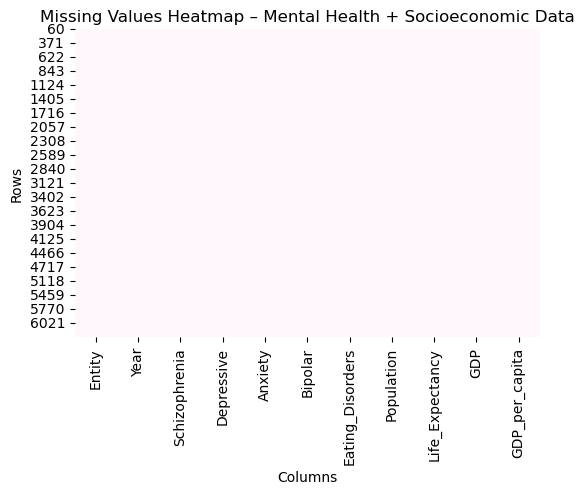

In [38]:
# Heatmap to check missing values in the combined mental health + socioeconomic dataset
plt.figure(figsize=(6,4))
sns.heatmap(mh_socio_df.isnull(), cbar=False, cmap="PuBuGn")
plt.title("Missing Values Heatmap – Mental Health + Socioeconomic Data")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [39]:
# Count unique countries in the dataset
mh_socio_df["Entity"].nunique()

162

### Exploratory Data Analysis 

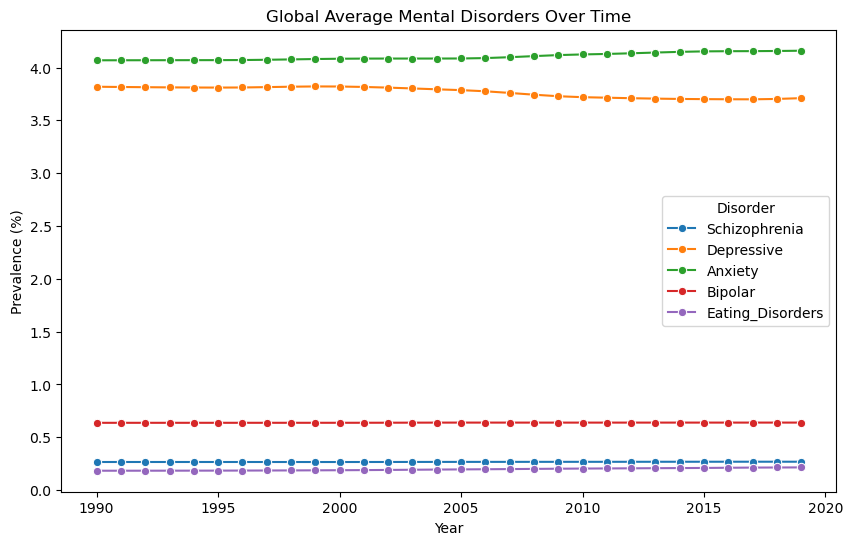

In [40]:
# Visualize global average trend of each mental disorder from 1990–2019
# List of mental disorder columns to analyze
disorder_cols = ["Schizophrenia", "Depressive", "Anxiety", "Bipolar", "Eating_Disorders"]

# Compute global average prevalence of each disorder per year
avg_mental = mh_df.groupby("Year")[disorder_cols].mean().reset_index()

# Reshape wide → long so seaborn can plot multiple disorders in one line chart
avg_mental_long = avg_mental.melt(
    id_vars="Year",
    value_vars=disorder_cols,
    var_name="Disorder",
    value_name="Prevalence"
)

# Line plot to show how global averages change over time
plt.figure(figsize=(10,6))
sns.lineplot(data=avg_mental_long, x="Year", y="Prevalence", hue="Disorder", marker="o")
plt.title("Global Average Mental Disorders Over Time")
plt.ylabel("Prevalence (%)")
plt.xlabel("Year")
plt.legend(title="Disorder")
plt.show()


**Observation**

The global averages for all five mental health disorders show minimal variation between 1990 and 2019.
Anxiety remains the most prevalent condition worldwide (\~4%), followed by depressive disorders (\~3.7–3.8%).
Bipolar disorder, schizophrenia, and eating disorders show very small year-to-year fluctuations, indicating that global averages are relatively stable and do not shift dramatically over time.
Because these absolute trends are nearly flat, plotting the relative (%) change is more useful for highlighting subtle increases or decreases.

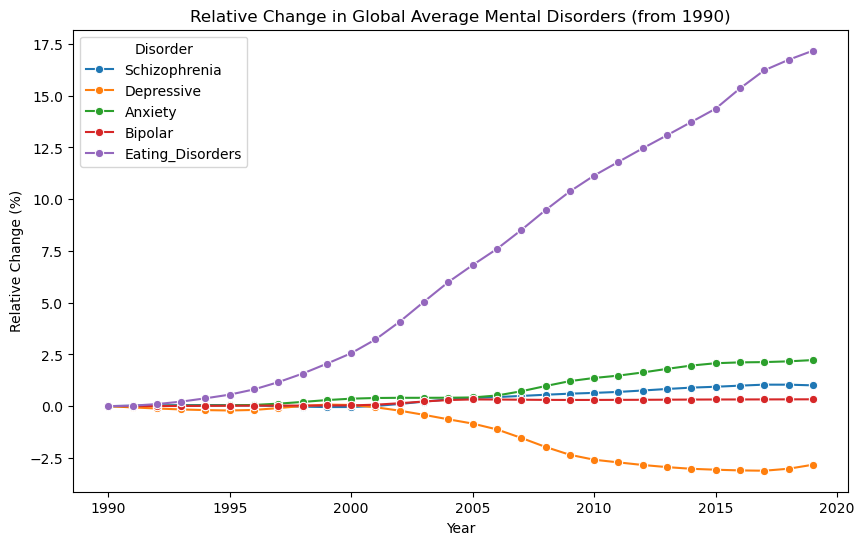

In [41]:
# Vizualize Relative Change in Global Average Mental Disorders (from 1990)
# Compute the baseline (1990) global average values for all mental disorders
baseline = avg_mental.loc[0, disorder_cols]

# Calculate % change relative to 1990 for each disorder over time
# Formula: ((value - baseline) / baseline) * 100
relative_change = avg_mental[disorder_cols].apply(
    lambda x: (x - baseline[x.name]) / baseline[x.name] * 100
)

# Keep the Year column for plotting
relative_change["Year"] = avg_mental["Year"]

# Convert to long format for seaborn line plot
relative_long = relative_change.melt(
    id_vars="Year", 
    var_name="Disorder", 
    value_name="Relative_Change (%)"
)

# Plot % change over time for each mental disorder
plt.figure(figsize=(10,6))
sns.lineplot(
    data=relative_long, 
    x="Year", 
    y="Relative_Change (%)", 
    hue="Disorder",
    marker="o"
)

plt.title("Relative Change in Global Average Mental Disorders (from 1990)")
plt.ylabel("Relative Change (%)")
plt.xlabel("Year")
plt.show()


**Observation**

* Eating disorders show the largest increase globally, rising by nearly +17% since 1990 — the steepest growth among all disorders.
* Anxiety disorders have increased steadily, showing a ~+2% rise over the period.
* Schizophrenia and bipolar disorder increased slightly, both staying under +1% relative growth.
* Depressive disorders show a consistent decline, dropping by about –2.5% since 1990.

In [42]:
# Vizualise top 15 Leading Countries by Prevalence of Major Mental Health Disorders
# Loop through each disorder column
for disorder in disorder_cols:

    # Compute average prevalence per country
    avg_country = (
        mh_df.groupby("Entity")[disorder]
        .mean()
        .sort_values(ascending=False)
    )

    # Select top 15 countries
    top15_countries = avg_country.head(15).index.tolist()

    # Filter dataset for these countries
    top15_df = mh_df[mh_df["Entity"].isin(top15_countries)].copy()

    # Sort countries for legend order
    top15_sorted = avg_country[top15_countries].sort_values(ascending=False).index.tolist()

    # Plot the line chart
    fig = px.line(
        top15_df,
        x="Year",
        y=disorder,
        color="Entity",
        markers=True,
        title=f"{disorder} Disorder Prevalence Over Time - Top 15 Countries",
        labels={disorder: f"{disorder} Prevalence (%)"},
        width=1000,
        height=600,
        category_orders={"Entity": top15_sorted}
    )

    # Update marker size and line width
    fig.update_traces(marker=dict(size=6), line=dict(width=2))

    # Update layout settings
    fig.update_layout(
        xaxis=dict(title="Year", tickangle=90),
        yaxis=dict(title=f"{disorder} Prevalence (%)"),
        hovermode="x unified",
        legend=dict(font=dict(size=10))
    )

    fig.show()


**Observations**

**Schizophrenia**
- United States remains highest with stable long-term levels.
- Most countries show minimal change over time.
- Differences between countries are small compared to other disorders.

**Depressive Disorders**
- Uganda and several African nations show the highest prevalence.
- 12 of the top 15 depressive-disorder countries are African nations.
- Trends include gradual increases followed by later declines.

**Anxiety Disorders**
- Portugal, Brazil, and New Zealand lead with the highest levels.
- Brazil shows a sharp rise around mid-2000s followed by decline.
- Several European countries show mild upward movement.

**Bipolar Disorder**
- New Zealand consistently records the highest prevalence.
- Most countries show stable, almost flat trends across years.

**Eating Disorders**
- Australia shows the highest and fastest increase over time.
- Most European microstates show steady upward trends.


In [43]:
# Socio-Economic Factors and Mental Health Disorders
# Population range
pop_min = mh_socio_df["Population"].min()
pop_max = mh_socio_df["Population"].max()

# Life Expectancy range
le_min = mh_socio_df["Life_Expectancy"].min()
le_max = mh_socio_df["Life_Expectancy"].max()

# GDP per capita range
gpc_min = mh_socio_df["GDP_per_capita"].min()
gpc_max = mh_socio_df["GDP_per_capita"].max()

print(f"Population range: {pop_min:,.0f} – {pop_max:,.0f}")
print(f"Life Expectancy range: {le_min:.1f} – {le_max:.1f}")
print(f"GDP per capita range: ${gpc_min:,.0f} – ${gpc_max:,.0f}")


Population range: 8,798 – 1,407,745,000
Life Expectancy range: 12.2 – 86.2
GDP per capita range: $167 – $185,583


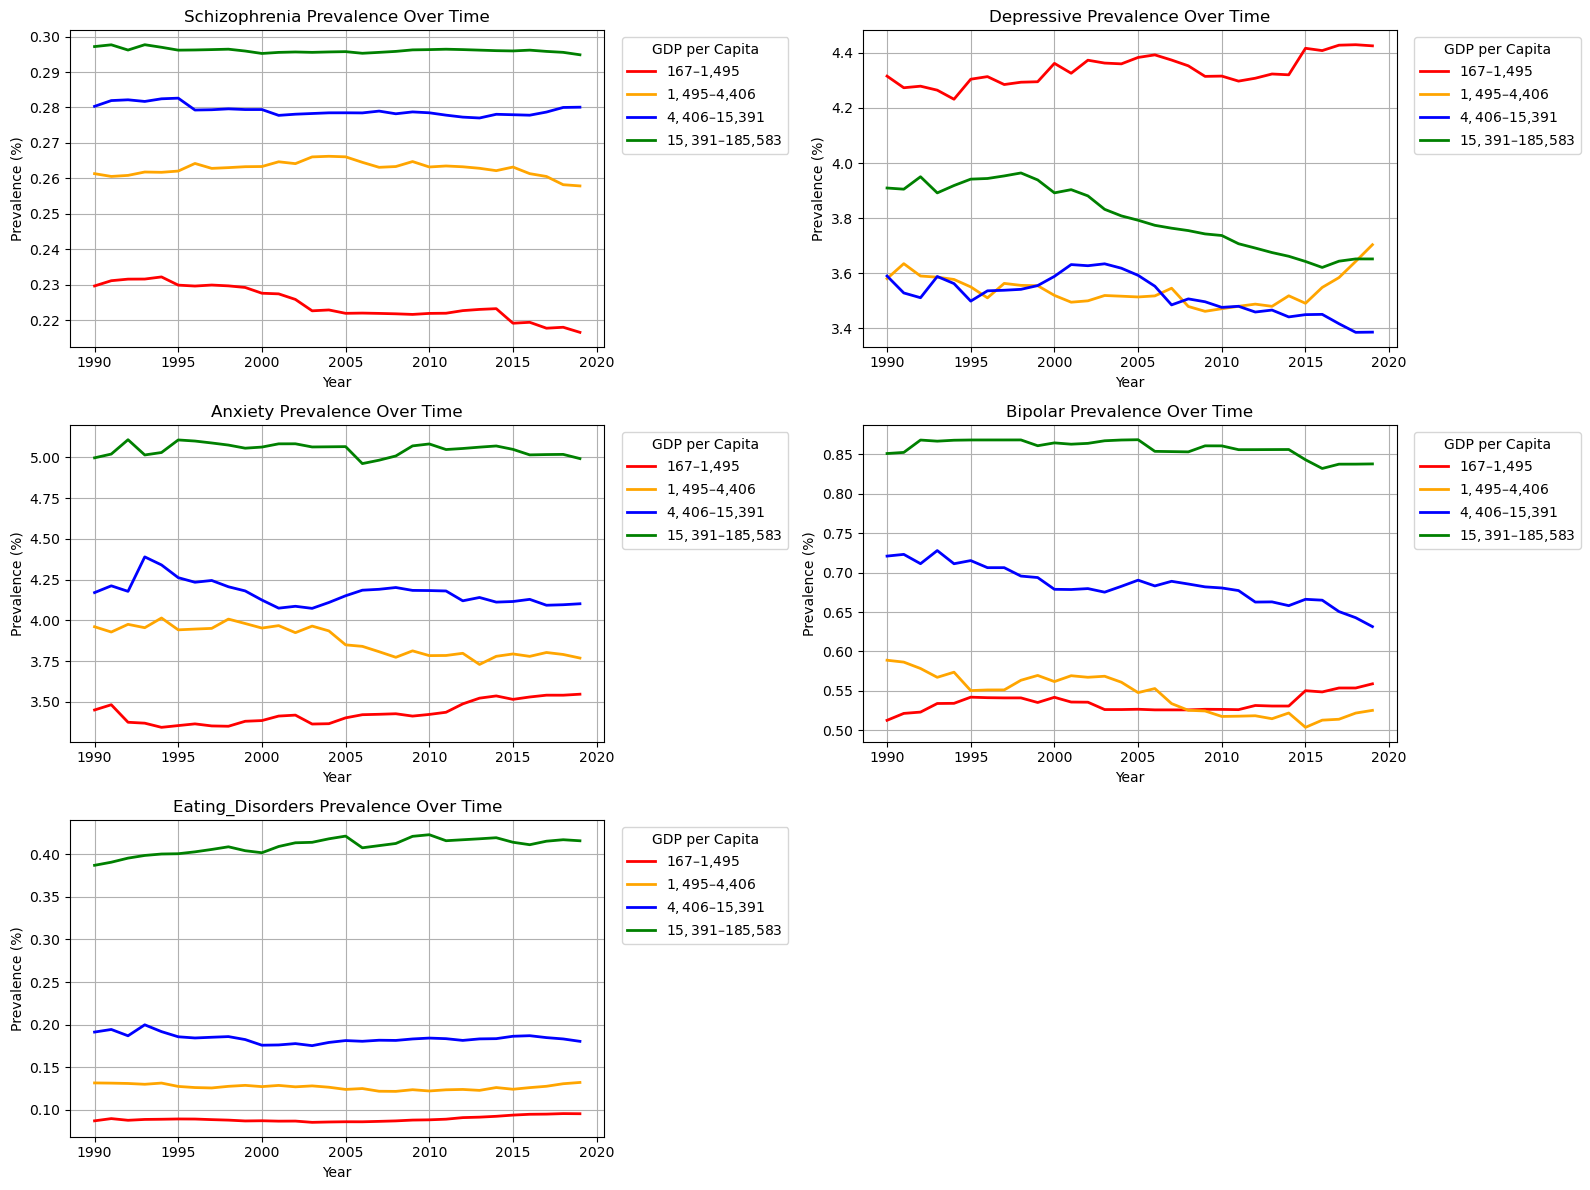

In [44]:
# GDP per Capita Quartile Analysis for All Disorders
# Create quartile groups for GDP per capita
quartiles_gdp = pd.qcut(mh_socio_df['GDP_per_capita'], q=4)

# Generate readable labels for each quartile range
quartile_labels_gdp = [
    f"${interval.left:,.0f} – ${interval.right:,.0f}"
    for interval in quartiles_gdp.cat.categories
]

# Assign GDP quartile label to each observation
mh_socio_df['GDP_group'] = pd.qcut(
    mh_socio_df['GDP_per_capita'],
    q=4,
    labels=quartile_labels_gdp
)

# Disorders included in the analysis
disorders = ["Schizophrenia", "Depressive", "Anxiety", "Bipolar", "Eating_Disorders"]

# Create a subplot grid for comparison
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

# Define colors for each quartile group
colors = ['red', 'orange', 'blue', 'green']

# Plot average prevalence over time for each GDP quartile
for i, disorder in enumerate(disorders):
    for j, group_label in enumerate(quartile_labels_gdp):
        group_df = mh_socio_df[mh_socio_df['GDP_group'] == group_label]
        avg_over_years = group_df.groupby("Year")[disorder].mean()

        axes[i].plot(
            avg_over_years.index,
            avg_over_years.values,
            label=group_label,
            color=colors[j],
            linewidth=2
        )

    axes[i].set_title(f"{disorder} Prevalence Over Time")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Prevalence (%)")

    # Place legend outside the plot area
    axes[i].legend(
        title="GDP per Capita",
        loc="upper left",
        bbox_to_anchor=(1.02, 1)
    )

    axes[i].grid(True)

# Remove unused subplot
fig.delaxes(axes[-1])

# Adjust layout so legends outside do not overlap the figure
plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


**Observations**

- Depressive disorders are consistently higher in low-GDP per capita countries, and this gap remains stable over time when compared to higher-GDP groups.  
- Eating disorders show a slight upward trend in high-GDP per capita countries, which aligns with patterns commonly observed in wealthy nations.  
- Anxiety, bipolar, and schizophrenia disorders appear slightly higher in high-GDP per capita countries, which is unexpected and may reflect better diagnosis/reporting rather than true prevalence differences.

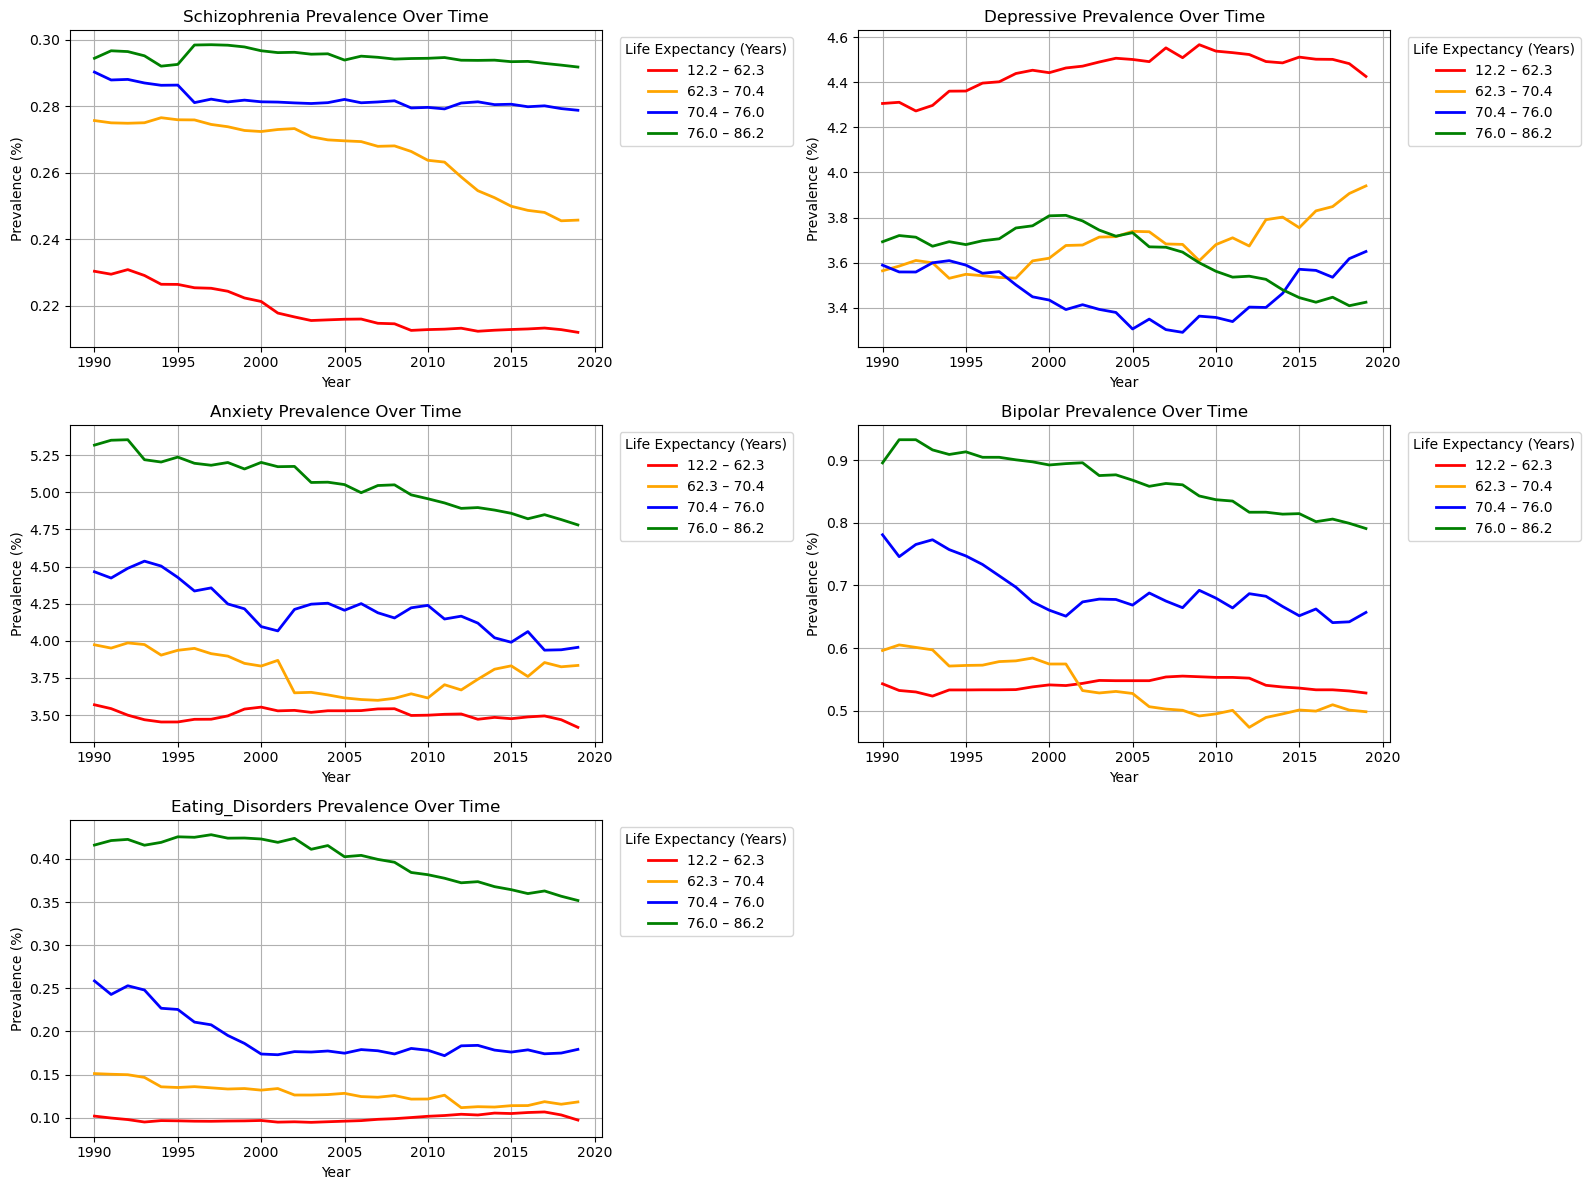

In [45]:
# Life expectancy Quartile Analysis for All Disorders
# Create quartile groups for Life Expectancy
quartiles_le = pd.qcut(mh_socio_df['Life_Expectancy'], q=4)

# Generate readable labels for each quartile range
quartile_labels_le = [
    f"{interval.left:.1f} – {interval.right:.1f}"
    for interval in quartiles_le.cat.categories
]

# Assign Life Expectancy quartile group
mh_socio_df['LE_group'] = pd.qcut(
    mh_socio_df['Life_Expectancy'],
    q=4,
    labels=quartile_labels_le
)

# Disorders included in the analysis
disorders = ["Schizophrenia", "Depressive", "Anxiety", "Bipolar", "Eating_Disorders"]

# Create subplot grid for comparison
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

# Define colors for the quartile groups
colors = ['red', 'orange', 'blue', 'green']

# Plot average prevalence over time for each Life Expectancy quartile
for i, disorder in enumerate(disorders):
    for j, group_label in enumerate(quartile_labels_le):
        group_df = mh_socio_df[mh_socio_df['LE_group'] == group_label]
        avg_over_years = group_df.groupby("Year")[disorder].mean()

        axes[i].plot(
            avg_over_years.index,
            avg_over_years.values,
            label=group_label,
            color=colors[j],
            linewidth=2
        )

    axes[i].set_title(f"{disorder} Prevalence Over Time")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Prevalence (%)")

    # Legend placed outside
    axes[i].legend(
        title="Life Expectancy (Years)",
        loc="upper left",
        bbox_to_anchor=(1.02, 1)
    )

    axes[i].grid(True)

# Remove unused subplot
fig.delaxes(axes[-1])

# Adjust layout for external legends
plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


**Observations**
  
- Depressive disorders remain consistently higher in low–life-expectancy countries, and this gap stays stable over time when compared to higher-life-expectancy groups.
- Anxiety, bipolar, and eating disorders show a downward trend in high–life-expectancy countries, suggesting improved mental-health awareness and management over time.
- Schizophrenia shows minimal change across all life-expectancy groups, reflecting its globally stable prevalence.

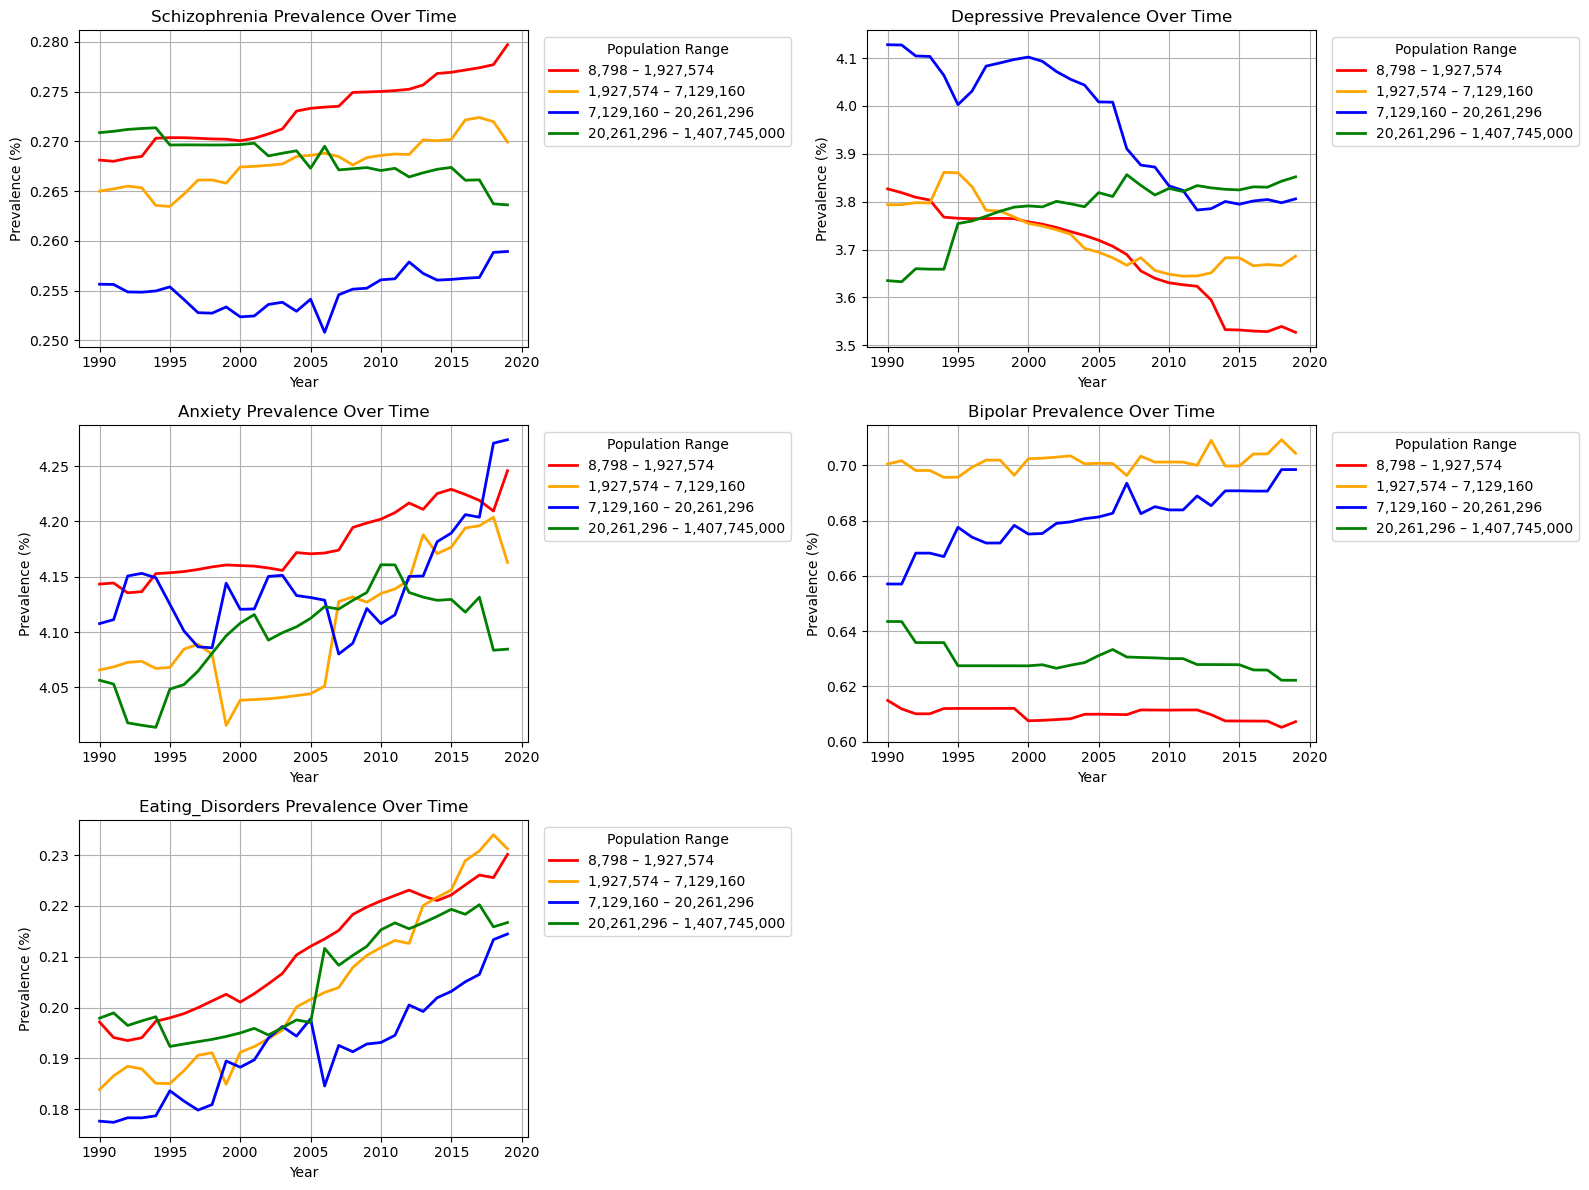

In [46]:
# Population Quartile Analysis for All Disorders
# Create quartile groups for Population
quartiles_pop = pd.qcut(mh_socio_df['Population'], q=4)

# Generate readable labels for Population ranges
quartile_labels_pop = [
    f"{interval.left:,.0f} – {interval.right:,.0f}"
    for interval in quartiles_pop.cat.categories
]

# Assign Population quartile group
mh_socio_df['POP_group'] = pd.qcut(
    mh_socio_df['Population'],
    q=4,
    labels=quartile_labels_pop
)

# Disorders included in the analysis
disorders = ["Schizophrenia", "Depressive", "Anxiety", "Bipolar", "Eating_Disorders"]

# Create subplot grid for comparison
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

# Define colors for each quartile group
colors = ['red', 'orange', 'blue', 'green']

# Plot average prevalence over time for each Population quartile
for i, disorder in enumerate(disorders):
    for j, group_label in enumerate(quartile_labels_pop):
        group_df = mh_socio_df[mh_socio_df['POP_group'] == group_label]
        avg_over_years = group_df.groupby("Year")[disorder].mean()

        axes[i].plot(
            avg_over_years.index,
            avg_over_years.values,
            label=group_label,
            color=colors[j],
            linewidth=2
        )

    axes[i].set_title(f"{disorder} Prevalence Over Time")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Prevalence (%)")

    # Legend placed outside
    axes[i].legend(
        title="Population Range",
        loc="upper left",
        bbox_to_anchor=(1.02, 1)
    )

    axes[i].grid(True)

# Remove unused subplot
fig.delaxes(axes[-1])

# Adjust layout for external legends
plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


**Observations**

- Depressive disorders show a declining trend across smaller-population countries, while larger-population countries maintain slightly lower and more stable prevalence over time.  
- Anxiety, bipolar, and eating disorders display a clear upward trend—most prominently in smaller-population countries—suggesting increasing burden or improved reporting in these regions.  
- Schizophrenia remains largely stable across all population groups, with only minor fluctuations and no significant long-term change.


### Clustering and Dimensionality Reduction

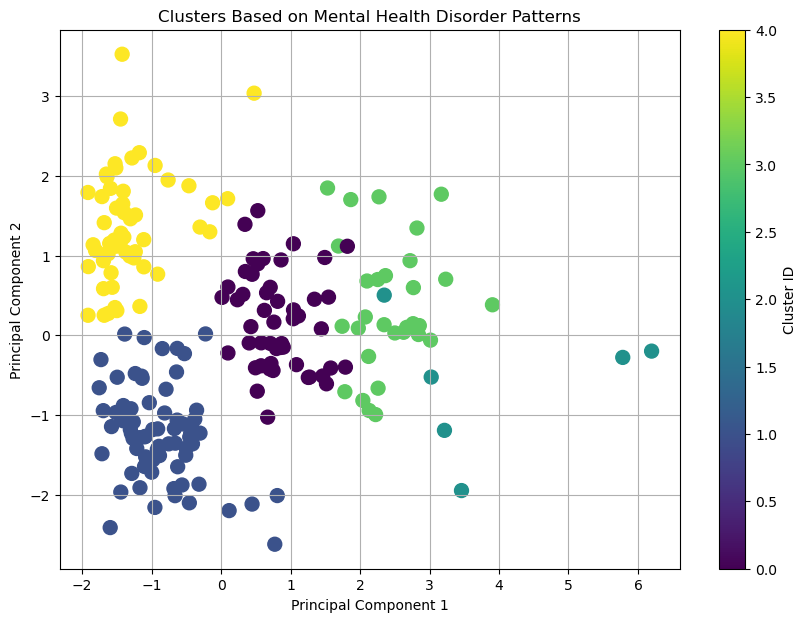

In [47]:
# Visualize clusters based on mental-health disorder patterns

# Compute country-level averages
df_cluster_mh = mh_df.groupby("Entity")[disorder_cols].mean().reset_index()

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_mh[disorder_cols])

# Run K-Means clustering (5 groups)
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster_mh["Cluster"] = kmeans.fit_predict(X_scaled)

# Reduce dimensions with PCA for plotting
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_cluster_mh["PC1"] = components[:, 0]
df_cluster_mh["PC2"] = components[:, 1]

# Plot clusters in PCA space
plt.figure(figsize=(10,7))
plt.scatter(
    df_cluster_mh["PC1"], df_cluster_mh["PC2"],
    c=df_cluster_mh["Cluster"], cmap="viridis", s=100
)
plt.title("Clusters Based on Mental Health Disorder Patterns")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label="Cluster ID")
plt.show()


In [48]:
# See all countries in each cluster
for c in sorted(df_cluster_mh["Cluster"].unique()):
    print(f"\n===== Cluster {c} =====")
    display(df_cluster_mh[df_cluster_mh["Cluster"] == c][["Entity"] + disorder_cols])



===== Cluster 0 =====


Entity  Schizophrenia  Depressive   Anxiety  \
3                             Algeria       0.249057    4.132249  4.664659   
8                 Antigua and Barbuda       0.286527    2.929627  4.292473   
15                            Bahamas       0.285027    2.993168  4.269834   
16                            Bahrain       0.271138    4.868267  4.946668   
18                           Barbados       0.282435    3.081274  4.267525   
21                             Belize       0.269265    3.262946  4.084705   
23                            Bermuda       0.301907    3.327249  4.266898   
25                            Bolivia       0.263450    3.532391  5.654752   
35                             Canada       0.288482    3.307026  4.034142   
41                           Colombia       0.277546    2.403446  4.660421   
45                         Costa Rica       0.283747    3.152579  4.083784   
48                               Cuba       0.277258    4.177914  4.199330   
54                           Dominica       0.272477    2.979025  4.221061   
55                 Dominican Republic       0.271645    3.864254  4.460278   
57                            Ecuador       0.273296    3.330635  5.132898   
58                              Egypt       0.246394    3.810930  4.298456   
59                        El Salvador       0.266096    3.542989  4.301762   
65                  Europe (IHME GBD)       0.276139    3.591513  4.452671   
68                            Finland       0.263714    4.578251  3.848327   
77                            Grenada       0.274517    3.216949  4.230942   
79                          Guatemala       0.261905    3.959923  4.149038   
82                             Guyana       0.257837    4.906576  4.338620   
83                              Haiti       0.242069    3.653218  4.488456   
85                           Honduras       0.260139    3.122457  3.954871   
91                               Iraq       0.244032    3.721306  5.104804   
93                             Israel       0.303294    4.480488  3.542201   
95                            Jamaica       0.275882    2.940258  3.963182   
97                             Jordan       0.254053    4.335669  4.842814   
101                            Kuwait       0.277115    3.955283  4.321208   
108                             Libya       0.256939    4.322260  5.187868   
122                            Mexico       0.282791    3.294588  3.357075   
136                         Nicaragua       0.269206    3.307025  4.266199   
144                              Oman       0.264945    3.935736  4.617972   
148                            Panama       0.282243    2.956705  3.543173   
155                       Puerto Rico       0.290619    2.880506  4.410813   
156                             Qatar       0.282747    4.102407  4.285548   
160             Saint Kitts and Nevis       0.279624    3.928367  4.241158   
161                       Saint Lucia       0.275449    3.237210  4.248799   
162  Saint Vincent and the Grenadines       0.271110    3.254450  4.218775   
166                      Saudi Arabia       0.262822    4.090733  4.438474   
182                          Suriname       0.272355    4.645062  4.099252   
185                             Syria       0.245306    4.010069  5.367970   
193               Trinidad and Tobago       0.280315    3.851104  3.776116   
194                           Tunisia       0.252929    5.024761  5.000542   
195                            Turkey       0.247590    4.073236  4.325624   
200              United Arab Emirates       0.281002    3.668199  4.134772   
201                    United Kingdom       0.255815    4.172420  4.379163   
203      United States Virgin Islands       0.293536    3.251971  4.288893   
208                         Venezuela       0.277377    3.203903  3.830694   

      Bipolar  Eating_Disorders  
3    0.756328          0.195034  
8    0.946602          0.257645  
15   0.899265          0.293


===== Cluster 1 =====


Entity  Schizophrenia  Depressive   Anxiety  \
2                          Albania       0.283351    2.434626  3.734468   
5                   American Samoa       0.308631    2.639868  3.971686   
10                         Armenia       0.277858    2.872779  3.143817   
11                 Asia (IHME GBD)       0.290808    3.291311  3.273699   
14                      Azerbaijan       0.276144    2.700290  2.530468   
..                             ...            ...         ...       ...   
199                        Ukraine       0.271489    4.238806  3.024717   
204  Upper-middle-income countries       0.290155    3.182751  3.936043   
206                     Uzbekistan       0.266031    3.233722  2.023895   
207                        Vanuatu       0.271230    3.019851  3.953618   
209                        Vietnam       0.314578    2.537679  2.182671   

      Bipolar  Eating_Disorders  
2    0.542134          0.113957  
5    0.279646          0.130640  
10   0.541822          0.105046  
11   0.328355          0.113428  
14   0.522651          0.117180  
..        ...               ...  
199  0.521512          0.114137  
204  0.431442          0.131808  
206  0.511356          0.097025  
207  0.266532          0.074806  
209  0.336450          0.075435  

[74 rows x 6 columns]


===== Cluster 2 =====


Entity  Schizophrenia  Depressive   Anxiety   Bipolar  \
12       Australia       0.388553    4.575426  5.513212  1.121328   
76       Greenland       0.378636    6.287225  4.785209  0.635480   
92         Ireland       0.359360    4.154150  6.648440  0.699331   
134    Netherlands       0.379374    3.538990  6.641262  0.786851   
135    New Zealand       0.389495    3.651437  7.369994  1.496859   
202  United States       0.449479    4.368208  5.730277  0.603378   

     Eating_Disorders  
12           0.889621  
76           0.454010  
92           0.380415  
134          0.329684  
135          0.564822  
202          0.442615


===== Cluster 3 =====


Entity  Schizophrenia  Depressive   Anxiety   Bipolar  \
4       America (IHME GBD)       0.341972    3.691891  5.489782  0.833155   
6                  Andorra       0.287515    3.588144  5.404067  0.931506   
9                Argentina       0.311239    2.535886  5.018959  1.012627   
13                 Austria       0.275570    3.296626  5.852258  0.901617   
20                 Belgium       0.274233    3.413489  4.994400  0.899132   
28                  Brazil       0.275675    4.110291  7.432758  1.112359   
39                   Chile       0.315486    3.981493  5.467286  0.972284   
49                  Cyprus       0.274377    3.028017  6.423497  0.908263   
52                 Denmark       0.225506    3.775861  4.843143  0.944634   
66     European Union (27)       0.277650    3.619754  5.050169  0.820387   
69                  France       0.268617    4.070869  6.333421  0.903444   
73                 Germany       0.260167    3.337654  6.117967  0.749852   
75                  Greece       0.272742    5.285475  5.627343  0.905907   
84   High-income countries       0.330468    3.600706  4.844555  0.734885   
87                 Iceland       0.277495    3.010789  5.094000  0.899687   
90                    Iran       0.253136    4.684949  7.190839  0.816767   
94                   Italy       0.296647    3.686756  5.312269  0.882402   
105                Lebanon       0.253511    4.893581  6.132263  0.941585   
112             Luxembourg       0.280031    3.469954  5.329732  0.897121   
118                  Malta       0.275670    3.063263  6.263409  0.914693   
125                 Monaco       0.293360    4.050057  5.450498  0.899579   
143                 Norway       0.283070    3.090733  6.889298  0.832240   
150               Paraguay       0.274642    3.572439  6.175805  1.090247   
151                   Peru       0.275074    2.290162  5.484118  0.920015   
154               Portugal       0.268791    4.812644  7.908541  0.874846   
164             San Marino       0.283016    4.074814  5.495143  0.916551   
179                  Spain       0.265590    4.096359  4.770798  0.922100   
183                 Sweden       0.279752    4.202842  4.767158  0.972313   
184            Switzerland       0.280229    3.871359  6.633834  0.938887   
205                Uruguay       0.311808    2.684386  5.065871  0.960706   

     Eating_Disorders  
4            0.299468  
6            0.497991  
9            0.308481  
13           0.505193  
20           0.403408  
28           0.213727  
39           0.313572  
49           0.380821  
52           0.442787  
66           0.377035  
69           0.441154  
73           0.402653  
75           0.422124  
84           0.397916  
87           0.414354  
90           0.225150  
94           0.533075  
105          0.207539  
112          0.517864  
118          0.364063  
125          0.771963  
143          0.438345  
150          0.197726  
151          0.274116  
154          0.386554  
164          0.511920  
179          0.537677  
183          0.455780  
184          0.481178  
205          0.308115


===== Cluster 4 =====


Entity  Schizophrenia  Depressive   Anxiety  \
0                     Afghanistan       0.217139    4.968072  4.713665   
1               Africa (IHME GBD)       0.219843    4.557986  3.668081   
7                          Angola       0.215018    5.844577  3.970343   
22                          Benin       0.211936    4.410543  3.173820   
27                       Botswana       0.220411    4.283222  3.533433   
31                   Burkina Faso       0.205434    4.369421  3.083277   
32                        Burundi       0.200889    5.075459  3.572902   
34                       Cameroon       0.212359    4.583412  3.186536   
36                     Cape Verde       0.225844    4.878200  3.068652   
37       Central African Republic       0.194820    5.979900  4.257796   
38                           Chad       0.207980    5.211961  3.258610   
42                        Comoros       0.217025    4.286649  3.472994   
43                          Congo       0.214368    5.816502  3.733719   
46                  Cote d'Ivoire       0.212355    3.904165  3.195652   
51   Democratic Republic of Congo       0.202822    5.478118  3.817652   
53                       Djibouti       0.219107    4.441227  3.230226   
60              Equatorial Guinea       0.223663    5.834175  3.840534   
61                        Eritrea       0.206477    4.904912  3.683171   
63                       Eswatini       0.215332    4.345661  3.505617   
64                       Ethiopia       0.207960    4.858360  3.477683   
70                          Gabon       0.229255    5.672411  3.942196   
71                         Gambia       0.212103    5.616541  3.271596   
74                          Ghana       0.213191    4.360637  2.969730   
80                         Guinea       0.208582    4.318041  3.326169   
81                  Guinea-Bissau       0.203472    4.439382  3.070501   
99                          Kenya       0.214621    4.949576  3.382343   
106                       Lesotho       0.200265    5.335038  3.525707   
107                       Liberia       0.205201    4.706267  3.442177   
110          Low-income countries       0.216413    4.703680  3.616271   
113                    Madagascar       0.212348    4.775248  3.869010   
114                        Malawi       0.200556    4.174928  3.749776   
117                          Mali       0.209235    3.509913  2.654180   
120                    Mauritania       0.218735    3.643527  2.727863   
128                       Morocco       0.241656    5.140464  4.695804   
129                    Mozambique       0.199432    4.919478  3.974017   
131                       Namibia       0.218806    3.634853  3.451276   
133                         Nepal       0.271270    4.917827  3.055932   
137                         Niger       0.206905    4.179140  2.859606   
138                       Nigeria       0.219889    4.280644  2.950615   
147                     Palestine       0.248457    6.663175  5.472772   
159                        Rwanda       0.205382    5.458191  3.576606   
165         Sao Tome and Principe       0.220380    3.659330  3.059853   
167                       Senegal       0.215430    3.969087  2.885686   
170                  Sierra Leone       0.207462    4.349715  3.625415   
175                       Somalia       0.189797    4.862027  3.317196   
176                  South Africa       0.223499    4.137063  3.817768   
178                   South Sudan       0.228880    4.659824  4.835686   
181                         Sudan       0.231045    4.456718  4.679206   
188                      Tanzania       0.209447    4.702024  3.741541   
190                          Togo       0.207619    4.463894  3.546727   
198                        Uganda       0.204468    7.142991  3.953881   
210                         Yemen       0.230986    4.897088  4.784083   
211                        Zambia       0.209079    4.191195  3.830621   
212                      Zimbab

In [49]:
# View PCA component weights for PC1 and PC2
pca_weights = pd.DataFrame(
    pca.components_,          # PCA component vectors
    columns=disorder_cols,    # Disorder variables
    index=["PC1", "PC2"]      # Principal components
)
pca_weights


Schizophrenia  Depressive   Anxiety   Bipolar  Eating_Disorders
PC1       0.369357   -0.046644  0.516882  0.506342          0.581249
PC2      -0.570557    0.739098  0.181243  0.308679         -0.008198

**Observations**

- The PCA plot displays five clearly separated clusters, showing that countries differ strongly in their combined mental-health disorder patterns.  
- The horizontal spread (PC1) reflects overall internalizing-disorder severity (anxiety, bipolar, eating disorders), while PC2 contrasts higher depressive rates with lower schizophrenia levels.  
- **Cluster 1** (bottom-left) represents countries with low anxiety, low bipolar, and low eating-disorder levels—a compact, low-burden group.  
- **Cluster 0** (top-left) includes countries with moderate depressive disorders and consistently high anxiety, forming a broader mid-burden cluster.  
- **Cluster 3** (center-right) consists mainly of European regions (19 out of 30) with high anxiety, elevated bipolar, and higher eating-disorder prevalence—an internalizing-disorder-heavy cluster.  
- **Cluster 2** (far-right) contains a small set of countries (e.g., US, Australia, New Zealand) with very high anxiety, bipolar, and eating-disorder levels—the highest-burden group.  
- **Cluster 4** (lower-center/right) groups many African countries (39 out of 68) with high depressive disorders but low bipolar and eating-disorder rates—a depression-dominant profile.


### Next Steps

- Expand the analysis by incorporating additional socioeconomic indicators such as education index, unemployment rate, and healthcare spending to strengthen the relationship modeling.  
- Evaluate the optimal number of clusters using the Elbow Method to validate the current K-Means grouping.  
- Compare K-Means with an alternative clustering method such as DBSCAN to assess robustness 
